# Blue and green deployments with HAProxy
Blue-green deployments avoid having two versions at play at the same time by swapping one set of pods for another.

## Prerequisites
* Deploy the HAProxy controller
* Add any tolerations using spot instances
* Deploy the HPCC helm chart

## Prepare the yaml files
Create two eclwatch applications, one named blue and the other named green.  Green will be set to version 8.2.2-1, and the rest will use the current version 8.2.4.

In [ ]:
esp:
- name: blue
  ## Pre-configured esp applications include eclwatch, eclservices, and eclqueries
  application: eclwatch
  auth: none
  replicas: 1
  labels:
    tag: bluegreen
    group: blue
  service:
    port: 8888
    servicePort: 8010
    visibility: global

In [ ]:
- name: green
  image:
    root: "hpccsystems"
    name: platform-core
    version: 8.2.2-1
  ## Pre-configured esp applications include eclwatch, eclservices, and eclqueries
  application: eclwatch
  auth: none
  replicas: 1
  labels:
    tag: bluegreen
    group: green
  service:
    ## port can be used to change the local port used by the pod. If omitted, the default port (8880) is used
    port: 8888
    ## servicePort controls the port that this service will be exposed on, either internally to the cluster, or externally
    servicePort: 8010
    ## Specify visibility: local (or global) if you want the service available from outside the cluster. Typically, eclwatch and wsecl are published externally, while eclservices is designed for internal use.
    visibility: global

## Verify two versions of eclwatches
To verify that both blue and green are running, use the following command:

In [ ]:
kubectl get svc

You should see something like this:

In [ ]:
NAME                   TYPE           CLUSTER-IP     EXTERNAL-IP     PORT(S)                      AGE
blue                   LoadBalancer   10.0.53.89     20.97.152.176   8010:30767/TCP               6m56s
green                  LoadBalancer   10.0.194.41    20.75.106.206   8010:32349/TCP               6m56s

Now replace both eclwatch services with a new one, called bluegreen.  Delete the services using the following command:

In [ ]:
kubectl delete svc green
kubectl delete svc blue

You should see something like this:

In [ ]:
service "green" deleted
service "blue" deleted

Create a new file, for example eclwatch.yaml:

In [ ]:
# Source: hpcc/templates/esp.yaml
apiVersion: v1
kind: Service
metadata:
  name: "bluegreen"
spec:
  ports:
  - port: 8010
    protocol: TCP
    targetPort: 8888
  selector:
    #server: "blue"
    tag: bluegreen
  type: ClusterIP

Create this file:

In [ ]:
kubectl apply -f eclwatch.yaml

You should see something like this:

In [ ]:
service/bluegreen created

## Create an Ingress
Then, add a new route to your existing Ingress object that exposes this service, for example, bluegreen-ingress.yaml:

In [ ]:
apiVersion: networking.k8s.io/v1beta1
kind: Ingress
metadata:
  annotations:
    kubernetes.io/ingress.class: haproxy
    ingress.kubernetes.io/balance-algorithm: roundrobin
    ingress.kubernetes.io/blue-green-deploy: group=blue=1,group=green=1
    ingress.kubernetes.io/blue-green-mode: Deployment 
    ingress.kubernetes.io/ssl-redirect: "false"
  name: bluegreen
spec:
  rules:
  - http:
      paths:
      - backend:
          serviceName: bluegreen
          servicePort: 8010
        path: /
        # - host: bluegreen.52.232.213.165.nip.io

Apply the file:

In [ ]:
kubectl apply -f bluegreen-ingress.yaml

You should see something like this:

In [ ]:
ingress.networking.k8s.io/bluegreen created

Next, verify the ingress:

In [ ]:
kubectl get ingress

You should see the bluegreen ingress:

In [ ]:
NAME        CLASS    HOSTS   ADDRESS   PORTS   AGE
bluegreen   <none>   *                 80      68s

## Test the configuration
Get the IP address for HAProxy controller:

If deployed under the ingress-controller namespace, specify that: -n ingress-controller.

In [ ]:
kubectl get svc

You should see the ingress controller external IP:

In [ ]:
NAME                   TYPE           CLUSTER-IP     EXTERNAL-IP     PORT(S)                      AGE
haproxy-ingress        LoadBalancer   10.0.242.163   20.94.101.232   80:30409/TCP,443:30299/TCP   37m

To test, visit the IP address, refresh, and the two versions should vary after refreshing.

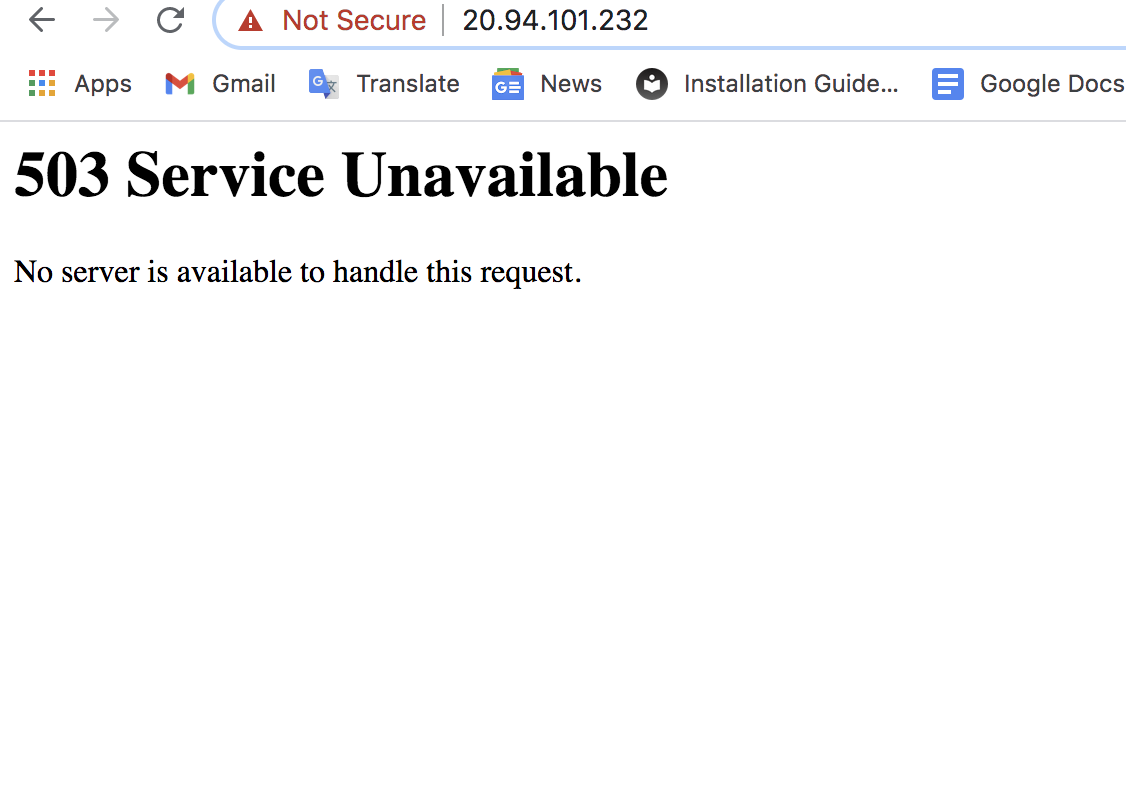